## Peer-to-Peer Federated Learning Model trained to predict Credit Card Fraud Detection

__________________________________

IMPORTING NECCESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import socket
import threading
import pickle
import os
import matplotlib.pyplot as plt

FUNCTION TO PLOT ACCURACY AND LOSS DURING FEDERATION ROUNDS

In [2]:
def plot_history(histories, peer_name):
    plt.figure(figsize=(12, 4))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(histories.history['accuracy'])
    plt.plot(histories.history['val_accuracy'])
    plt.title(f'{peer_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    
    plt.subplot(1, 2, 2)
    plt.plot(histories.history['loss'])
    plt.plot(histories.history['val_loss'])
    plt.title(f'{peer_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

LODING DATASETS FOR PEER1, PEER2 AND PEER3

In [3]:

data_peer1 = pd.read_csv('fraud1.csv')
data_peer2 = pd.read_csv('fraud2.csv')
data_peer3 = pd.read_csv('fraud3.csv')

LETS EXPLORE OUR DATASETS

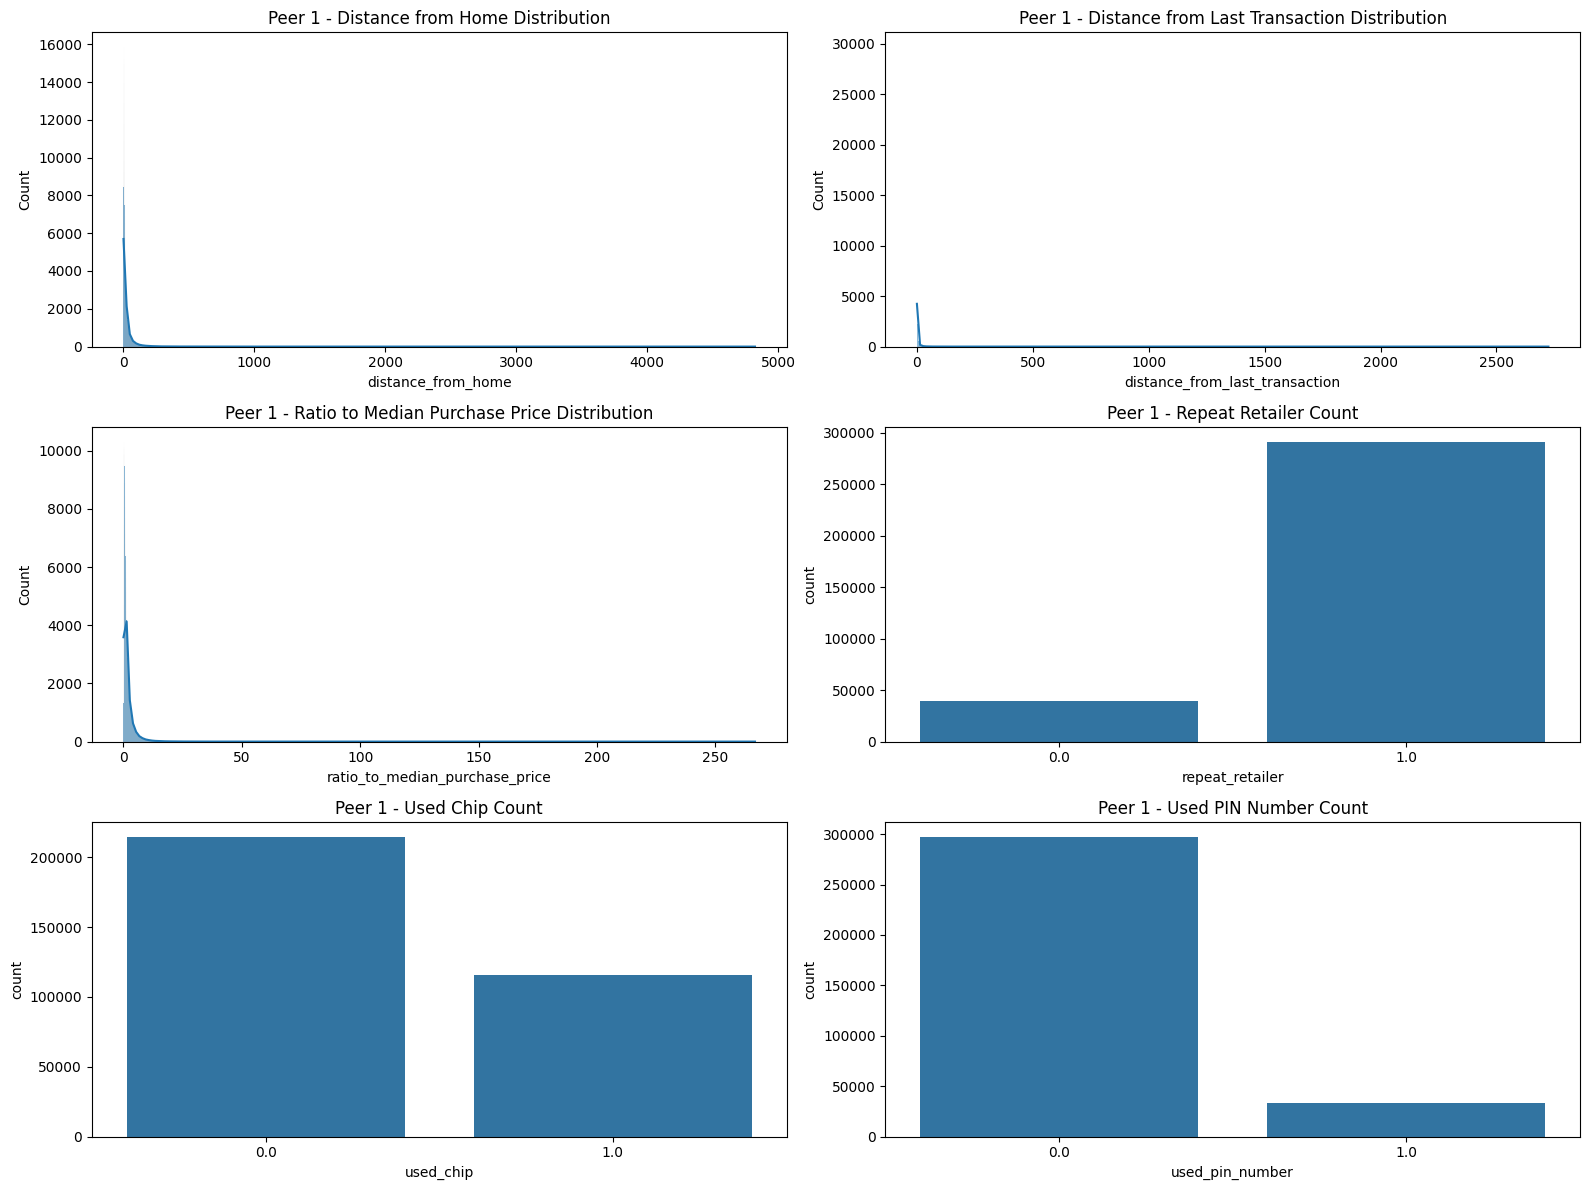

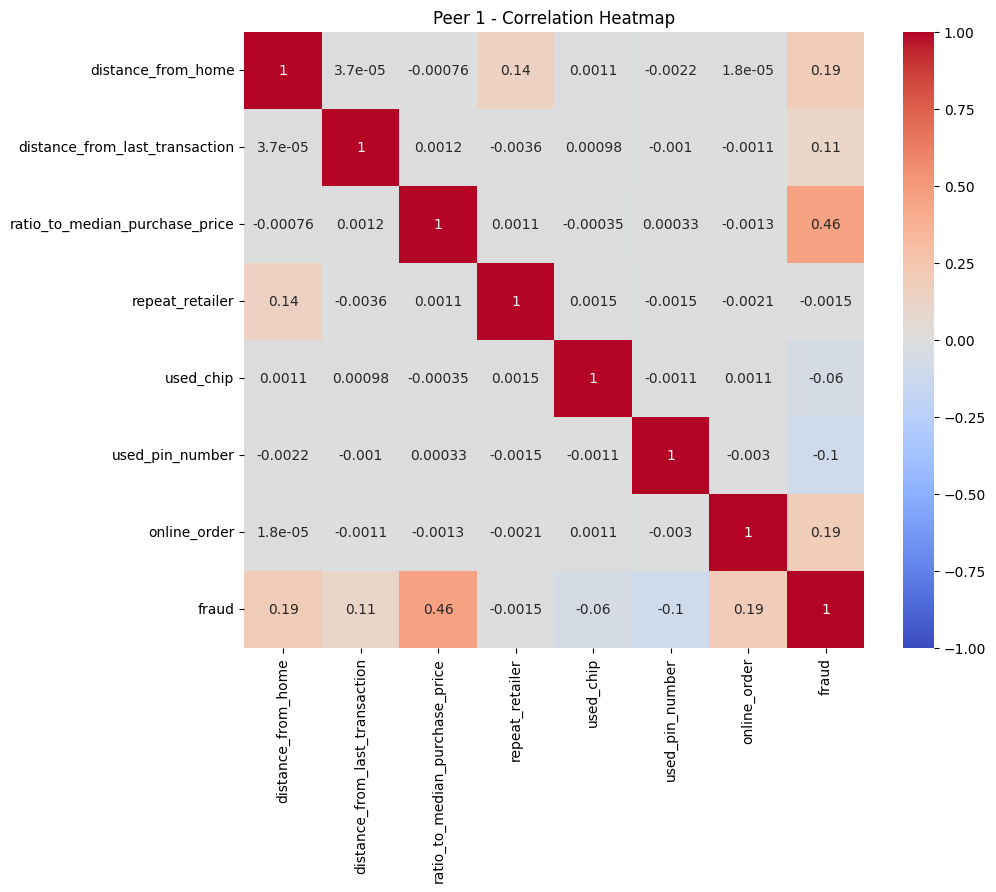

In [4]:
def plot_data_summary(data, peer_name):
    plt.figure(figsize=(16, 12))
    
   
    plt.subplot(3, 2, 1)
    sns.histplot(data['distance_from_home'], kde=True)
    plt.title(f'{peer_name} - Distance from Home Distribution')

    plt.subplot(3, 2, 2)
    sns.histplot(data['distance_from_last_transaction'], kde=True)
    plt.title(f'{peer_name} - Distance from Last Transaction Distribution')

    plt.subplot(3, 2, 3)
    sns.histplot(data['ratio_to_median_purchase_price'], kde=True)
    plt.title(f'{peer_name} - Ratio to Median Purchase Price Distribution')

    plt.subplot(3, 2, 4)
    sns.countplot(x='repeat_retailer', data=data)
    plt.title(f'{peer_name} - Repeat Retailer Count')

    plt.subplot(3, 2, 5)
    sns.countplot(x='used_chip', data=data)
    plt.title(f'{peer_name} - Used Chip Count')

    plt.subplot(3, 2, 6)
    sns.countplot(x='used_pin_number', data=data)
    plt.title(f'{peer_name} - Used PIN Number Count')

    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'{peer_name} - Correlation Heatmap')
    plt.show()


plot_data_summary(data_peer1, 'Peer 1')


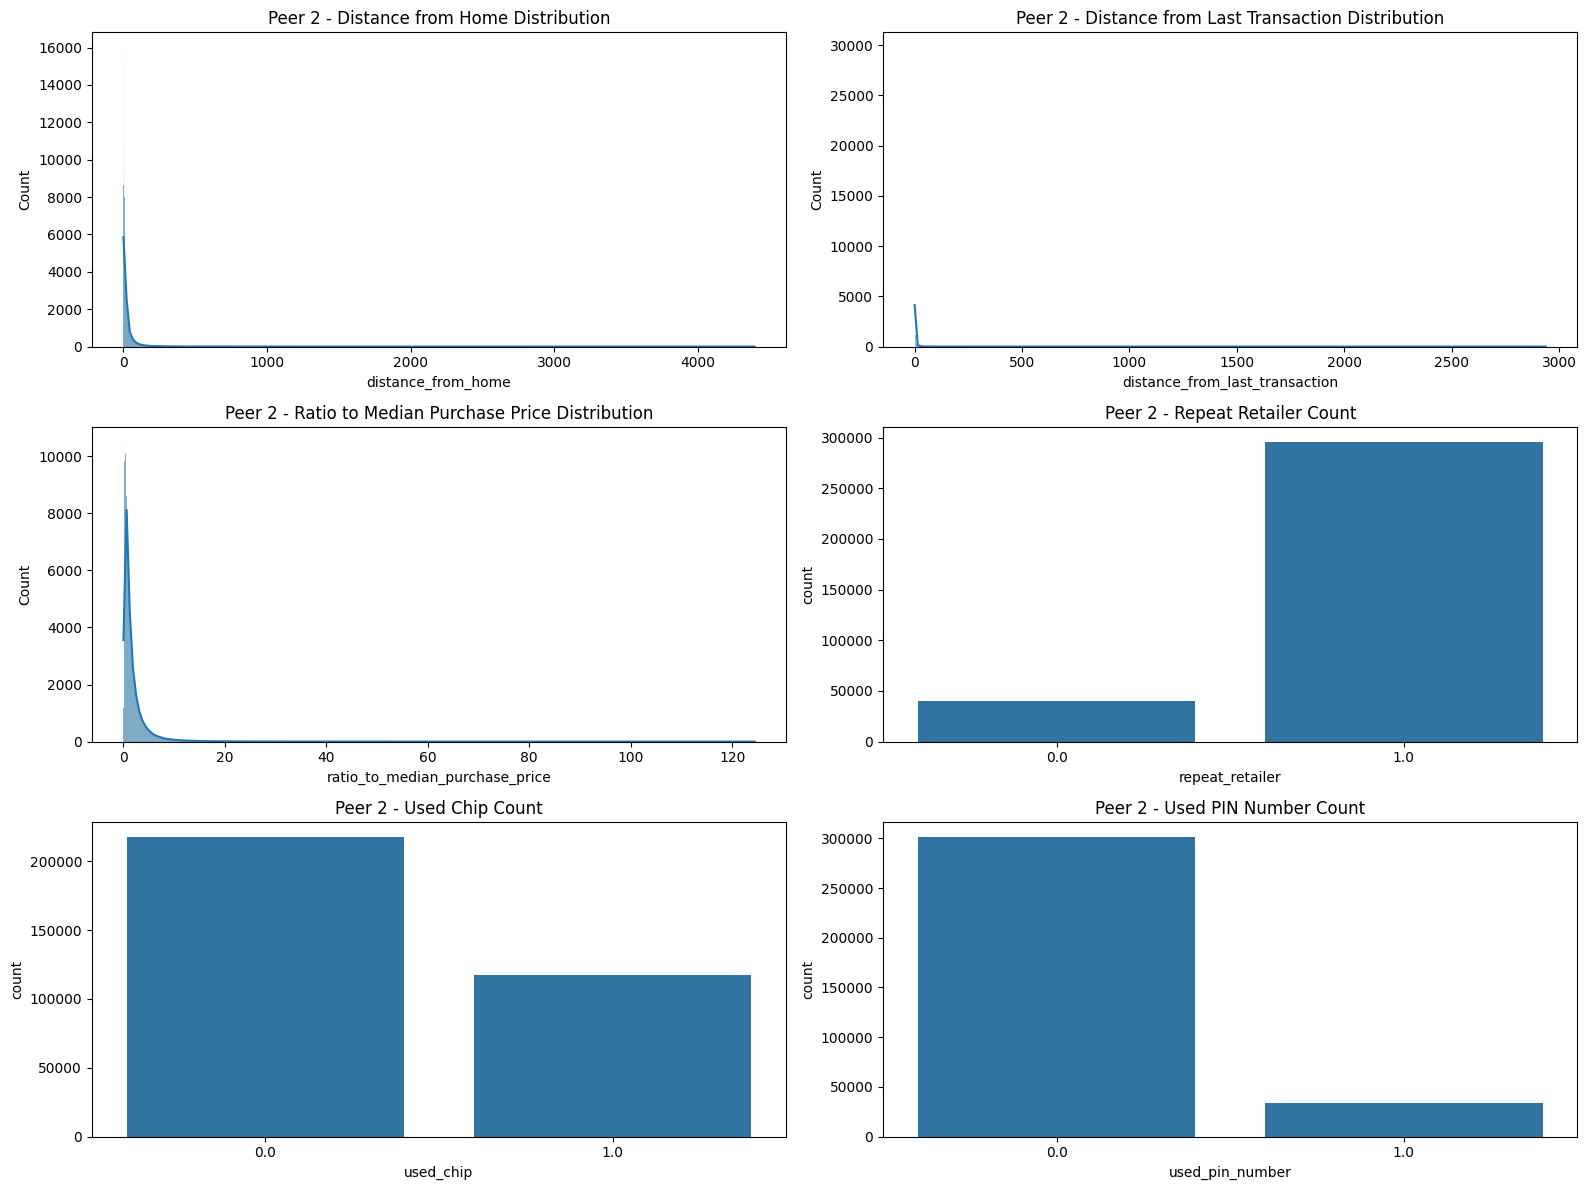

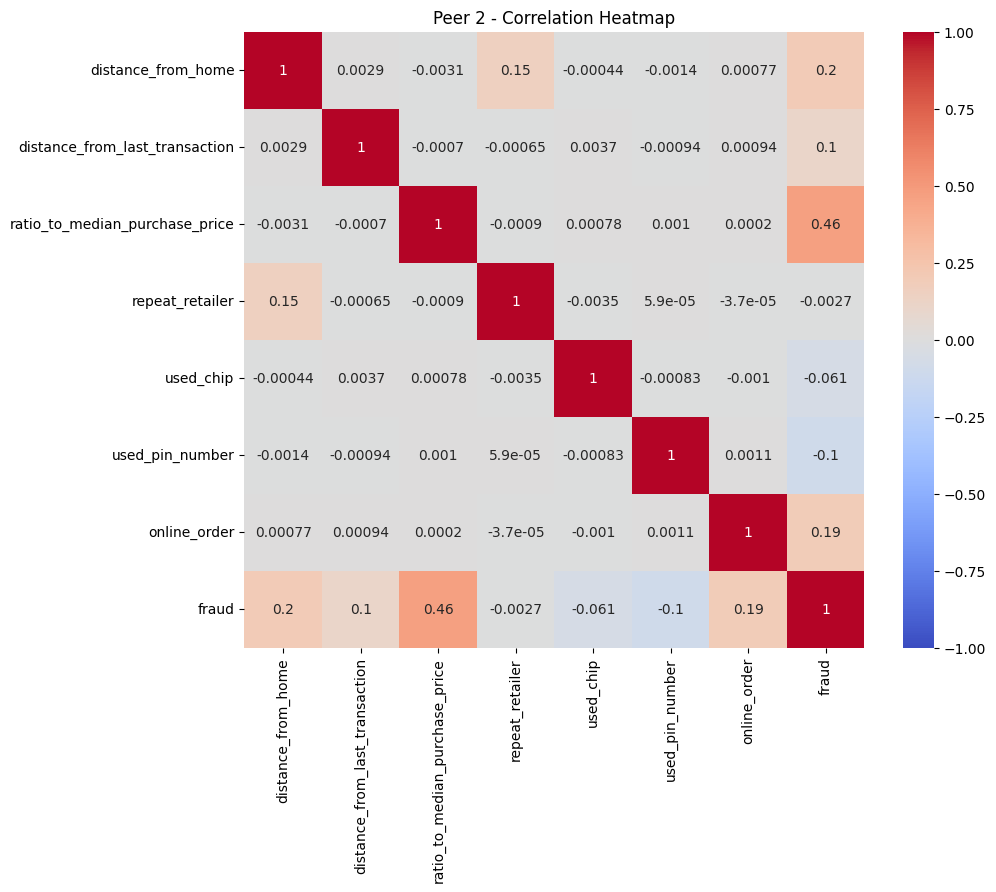

In [5]:
plot_data_summary(data_peer2, 'Peer 2')

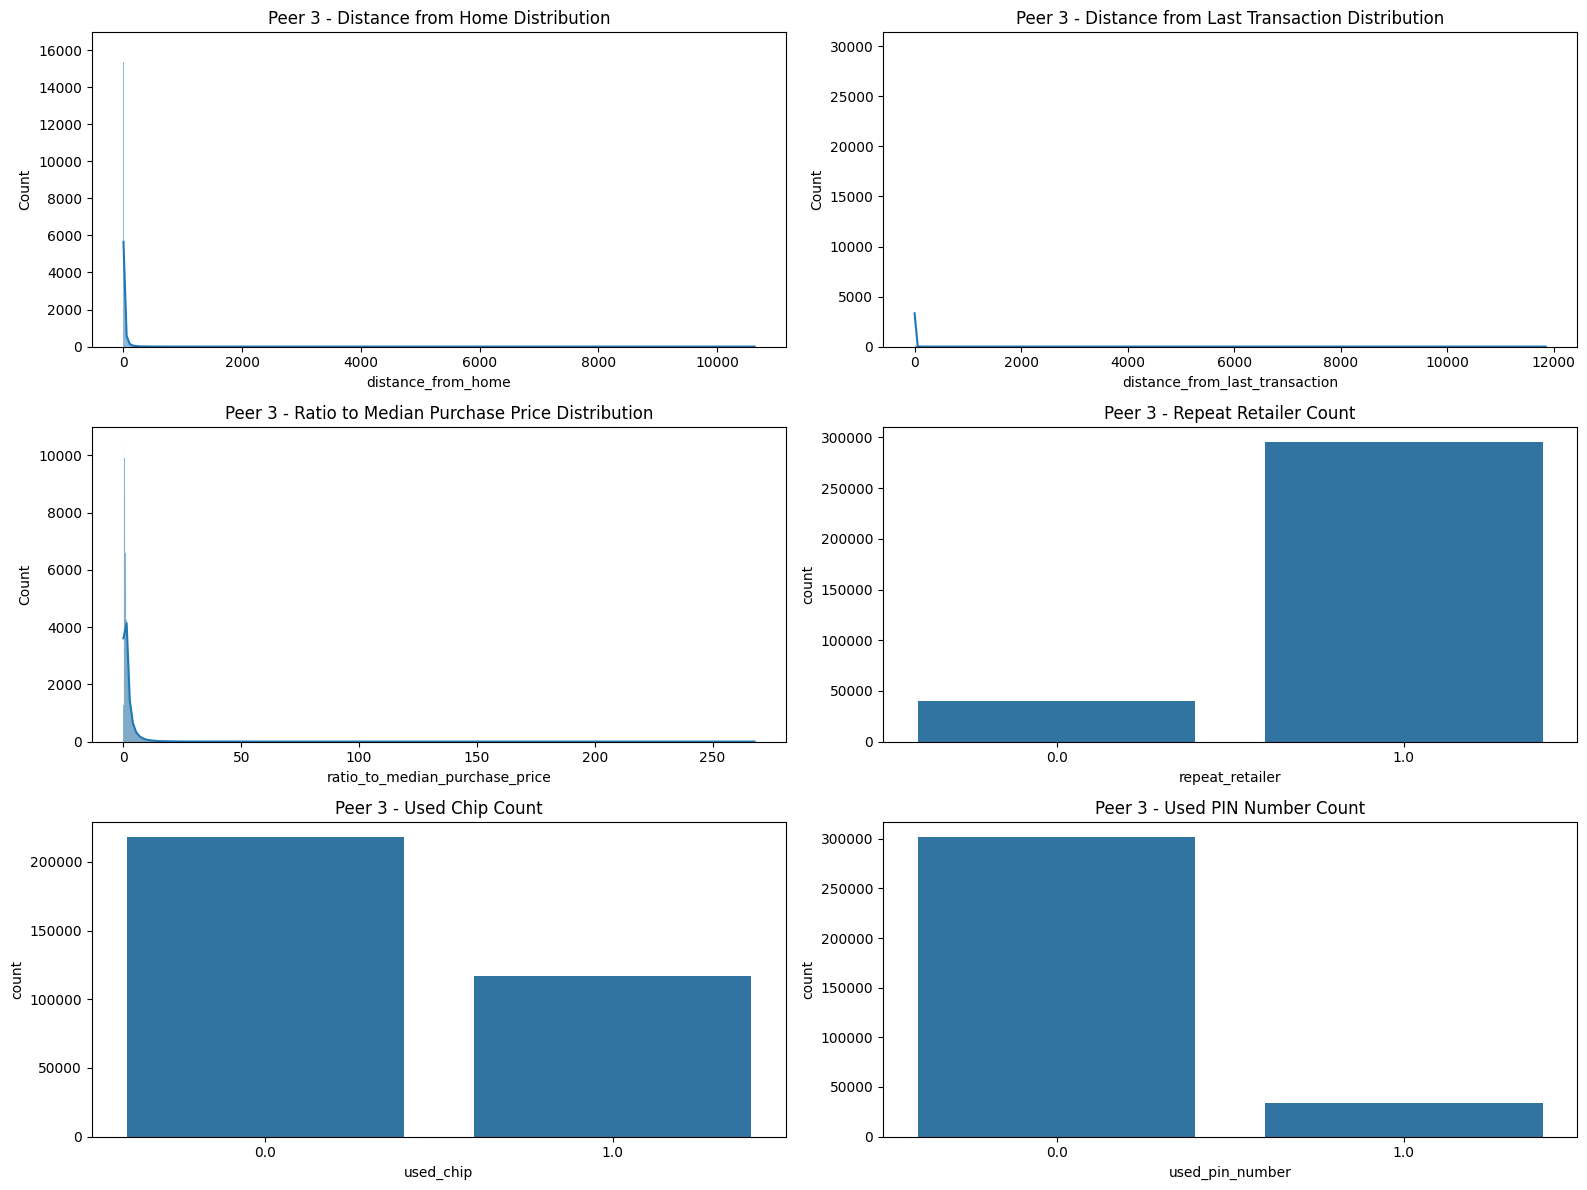

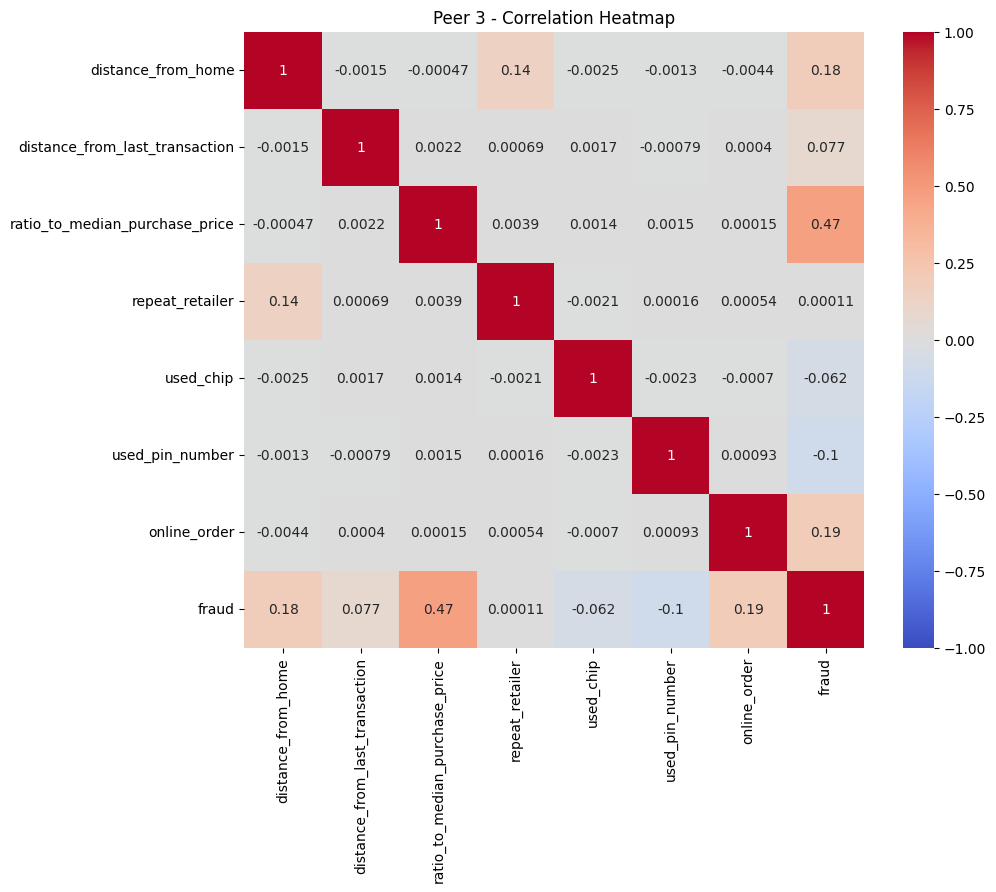

In [6]:
plot_data_summary(data_peer3, 'Peer 3')

GENERATING PUBLIC AND PRIVATE KEYS FOR THREE PEERS

In [7]:

def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1())
    public_key = private_key.public_key()

   
    private_pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.TraditionalOpenSSL,
        encryption_algorithm=serialization.NoEncryption()
    )

   
    public_pem = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )

    return private_pem, public_pem

ENCRYPTING KEYS

In [8]:
def encrypt_data(public_key_pem, data):
    public_key = serialization.load_pem_public_key(public_key_pem)
    symmetric_key = os.urandom(32)  
    
   
    cipher = Cipher(algorithms.AES(symmetric_key), modes.CFB8(os.urandom(16)))
    encryptor = cipher.encryptor()
    encrypted_data = encryptor.update(data) + encryptor.finalize()

    return symmetric_key, encrypted_data

DECRYPTING KEYS

In [9]:
def decrypt_data(private_key_pem, symmetric_key, encrypted_data):
    private_key = serialization.load_pem_private_key(private_key_pem, password=None)
    cipher = Cipher(algorithms.AES(symmetric_key), modes.CFB8(os.urandom(16)))
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()

    return decrypted_data

FILLING MISSIG VAUES WITH MEAN OF EACH DATASET

In [10]:

data_peer1.fillna(data_peer1.mean(), inplace=True)
data_peer2.fillna(data_peer2.mean(), inplace=True)
data_peer3.fillna(data_peer3.mean(), inplace=True)

SCALING OUR FEATURES

In [11]:

scaler = StandardScaler()


In [12]:
features_peer1 = scaler.fit_transform(data_peer1.drop('fraud', axis=1))
features_peer2 = scaler.fit_transform(data_peer2.drop('fraud', axis=1))
features_peer3 = scaler.fit_transform(data_peer3.drop('fraud', axis=1))

In [13]:
data_peer1_scaled = pd.DataFrame(features_peer1, columns=data_peer1.columns[:-1])
data_peer1_scaled['fraud'] = data_peer1['fraud'].values

data_peer2_scaled = pd.DataFrame(features_peer2, columns=data_peer2.columns[:-1])
data_peer2_scaled['fraud'] = data_peer2['fraud'].values

data_peer3_scaled = pd.DataFrame(features_peer3, columns=data_peer3.columns[:-1])
data_peer3_scaled['fraud'] = data_peer3['fraud'].values

SPLITING DATA FOR TRAINING AND TESTING WITH 80% AND 20%

In [14]:

X_train_peer1, X_test_peer1, y_train_peer1, y_test_peer1 = train_test_split(
    data_peer1_scaled.drop('fraud', axis=1), data_peer1_scaled['fraud'], test_size=0.2, random_state=42
)

X_train_peer2, X_test_peer2, y_train_peer2, y_test_peer2 = train_test_split(
    data_peer2_scaled.drop('fraud', axis=1), data_peer2_scaled['fraud'], test_size=0.2, random_state=42
)

X_train_peer3, X_test_peer3, y_train_peer3, y_test_peer3 = train_test_split(
    data_peer3_scaled.drop('fraud', axis=1), data_peer3_scaled['fraud'], test_size=0.2, random_state=42
)

DEFINING OUR DL MODEL WITH THREE LAYERS WITH ADAM OPTIMIZER AND BINARY_CROSSENTROPY

In [15]:

def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

FEDAVERAGE ALGORITHM FOR CALCULATING WEIGHTS OF EACH PEER

In [16]:
def average_weights(weight_list):
    if not weight_list:
        raise ValueError("No weights to average.")
    
    avg_weights = []
    for layer_weights in zip(*weight_list):
        layer_weights_array = [np.array(layer_weight) for layer_weight in layer_weights]
        avg_layer_weights = np.mean(layer_weights_array, axis=0)
        avg_weights.append(avg_layer_weights)
    
    return avg_weights

STARTING FEDERATED LEARNIG ROUNDS

In [17]:

def federated_learning_round(peers, epochs=1):
    local_weights = []
    histories = []
    for peer in peers:
        print(f"Training {peer['name']}'s model...")
        history = peer['model'].fit(peer['X_train'], peer['y_train'], epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)
        local_weights.append(peer['model'].get_weights())
        histories.append(history)
    
    avg_weights = average_weights(local_weights)
    
    for peer in peers:
        peer['model'].set_weights(avg_weights)
    
    print("Federated learning round completed.")
    return histories


START SERVER WITH HOST, PORT AND PRIVATE KEY

In [18]:
def start_server(host, port, handler, private_key_pem):
    server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server.bind((host, port))
    server.listen(5)
    print(f"Server started at {host}:{port}")
    
    while True:
        client_socket, addr = server.accept()
        print(f"Connection from {addr} has been established.")
        threading.Thread(target=handler, args=(client_socket, private_key_pem)).start()


In [19]:
def send_data(target_host, target_port, data, public_key_pem):
    symmetric_key, encrypted_data = encrypt_data(public_key_pem, pickle.dumps(data))
    
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client.connect((target_host, target_port))
    
    client.sendall(symmetric_key + b'\n' + encrypted_data)
    client.close()

In [20]:
def receive_data_handler(client_socket, private_key_pem):
    data = b""
    while True:
        packet = client_socket.recv(4096)
        if not packet: break
        data += packet
    
    symmetric_key, encrypted_data = data.split(b'\n', 1)
    decrypted_data = decrypt_data(private_key_pem, symmetric_key, encrypted_data)
    received_data = pickle.loads(decrypted_data)
    
    print("Data received:", received_data)
    client_socket.close()
    
    return received_data

GENERATE PUBLIC AND PRIVATE KEYS FOR EACH PEER WITH ECC

In [21]:

private_key_peer1, public_key_peer1 = generate_ecc_keys()
private_key_peer2, public_key_peer2 = generate_ecc_keys()
private_key_peer3, public_key_peer3 = generate_ecc_keys()

In [22]:

with open('private_key_peer1.pem', 'wb') as f:
    f.write(private_key_peer1)

with open('public_key_peer1.pem', 'wb') as f:
    f.write(public_key_peer1)

with open('private_key_peer2.pem', 'wb') as f:
    f.write(private_key_peer2)

with open('public_key_peer2.pem', 'wb') as f:
    f.write(public_key_peer2)

with open('private_key_peer3.pem', 'wb') as f:
    f.write(private_key_peer3)

with open('public_key_peer3.pem', 'wb') as f:
    f.write(public_key_peer3)

In [23]:
lock = threading.Lock()

def thread_safe_unpickle(file_path):
    with lock:
        try:
            with open(file_path, 'rb') as file:
                return pickle.load(file)
        except (pickle.UnpicklingError, EOFError, AttributeError, ImportError, IndexError) as e:
            print(f"Error unpickling file {file_path}: {e}")
            return None

DEFINING EACH PEER

In [24]:

peer1 = {
    'name': 'Peer1',
    'model': build_model(X_train_peer1.shape[1]),
    'X_train': X_train_peer1,
    'y_train': y_train_peer1,
    'X_test': X_test_peer1,
    'y_test': y_test_peer1,
    'host': '127.0.0.1',
    'port': 5001,
    'private_key': private_key_peer1,
    'public_key': public_key_peer2  # Connects to Peer2
}

peer2 = {
    'name': 'Peer2',
    'model': build_model(X_train_peer2.shape[1]),
    'X_train': X_train_peer2,
    'y_train': y_train_peer2,
    'X_test': X_test_peer2,
    'y_test': y_test_peer2,
    'host': '127.0.0.1',
    'port': 5002,
    'private_key': private_key_peer2,
    'public_key': public_key_peer3  # Connects to Peer3
}

peer3 = {
    'name': 'Peer3',
    'model': build_model(X_train_peer3.shape[1]),
    'X_train': X_train_peer3,
    'y_train': y_train_peer3,
    'X_test': X_test_peer3,
    'y_test': y_test_peer3,
    'host': '127.0.0.1',
    'port': 5003,
    'private_key': private_key_peer3,
    'public_key': public_key_peer1  # Connects to Peer1
}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
peers = [peer1, peer2, peer3]


START SERVER FOR EACH PEER

In [26]:

for peer in peers:
    threading.Thread(target=start_server, args=(peer['host'], peer['port'], receive_data_handler, peer['private_key'])).start()

Server started at 127.0.0.1:5001Server started at 127.0.0.1:5002

Server started at 127.0.0.1:5003


In [27]:
print(f"\nRound {1} of federated learning:")
histories = federated_learning_round([peer1, peer2, peer3], epochs=5)


Round 1 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.


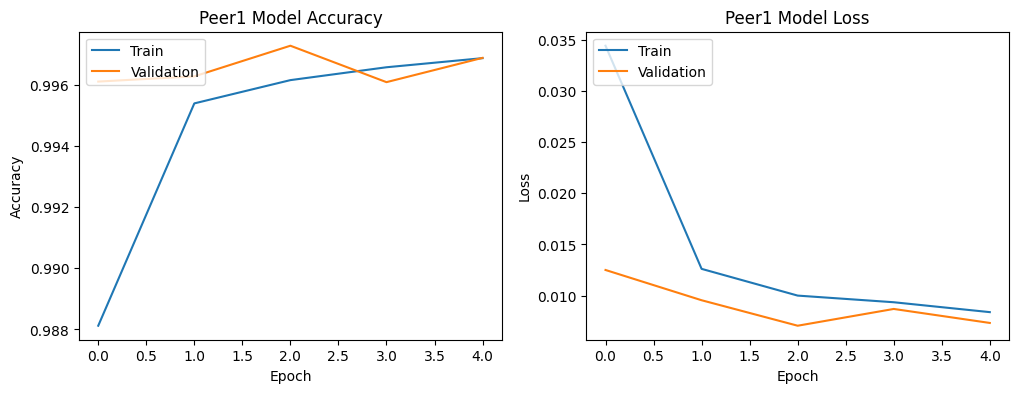

In [28]:

plot_history(histories[0], peer1['name'])

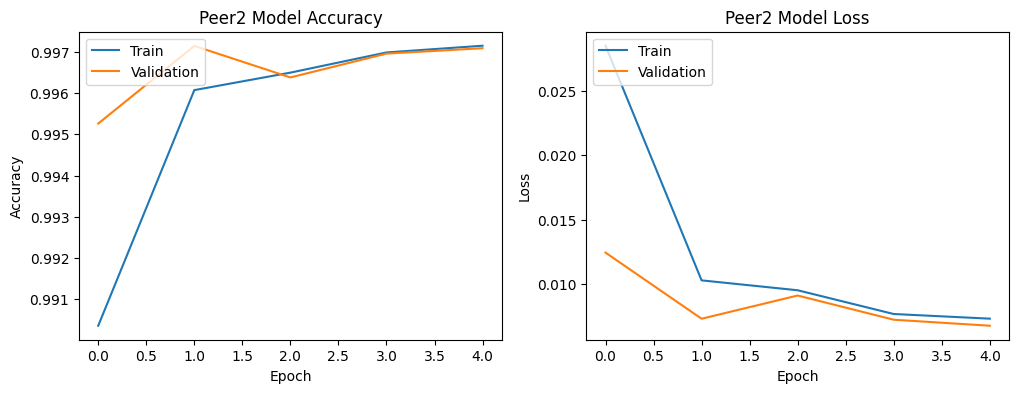

In [29]:
plot_history(histories[1], peer2['name'])

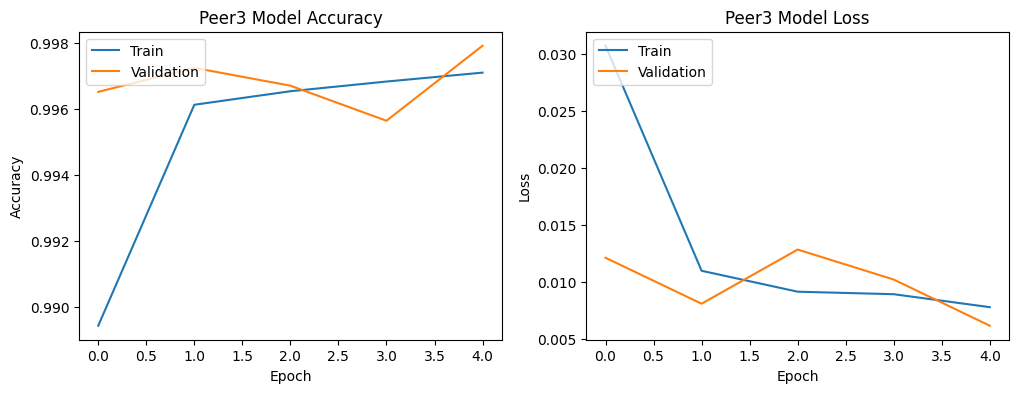

In [30]:
plot_history(histories[2], peer3['name'])

In [31]:

for round_num in range(9):  
    print(f"\nRound {round_num+1} of federated learning:")
    histories = federated_learning_round([peer1, peer2, peer3], epochs=5)



Round 1 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 2 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 3 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 4 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 5 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 6 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated learning round completed.

Round 7 of federated learning:
Training Peer1's model...
Training Peer2's model...
Training Peer3's model...
Federated lear

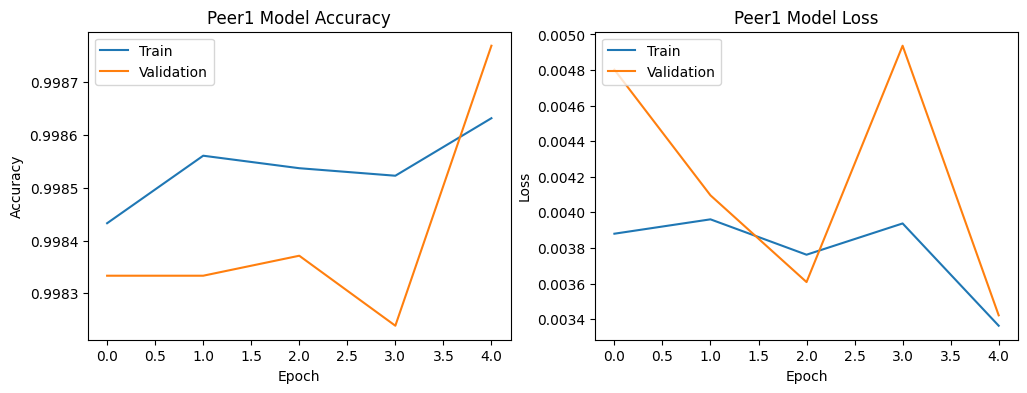

In [32]:
plot_history(histories[0], peer1['name'])

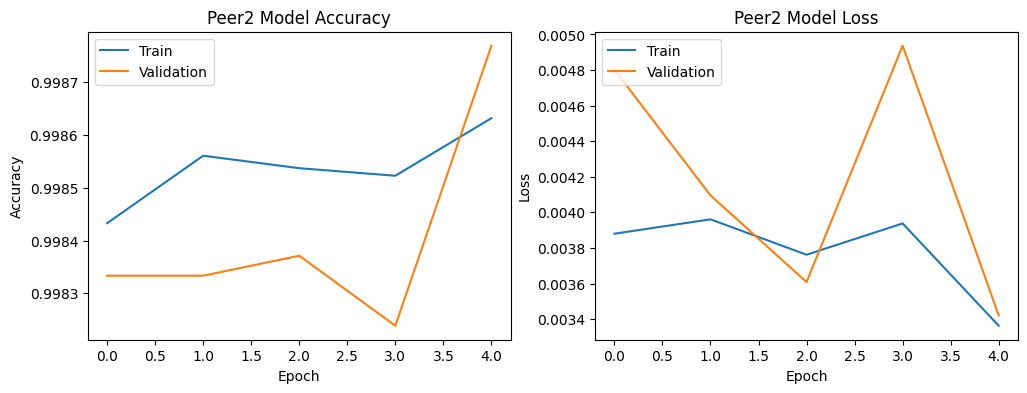

In [33]:
plot_history(histories[0], peer2['name'])

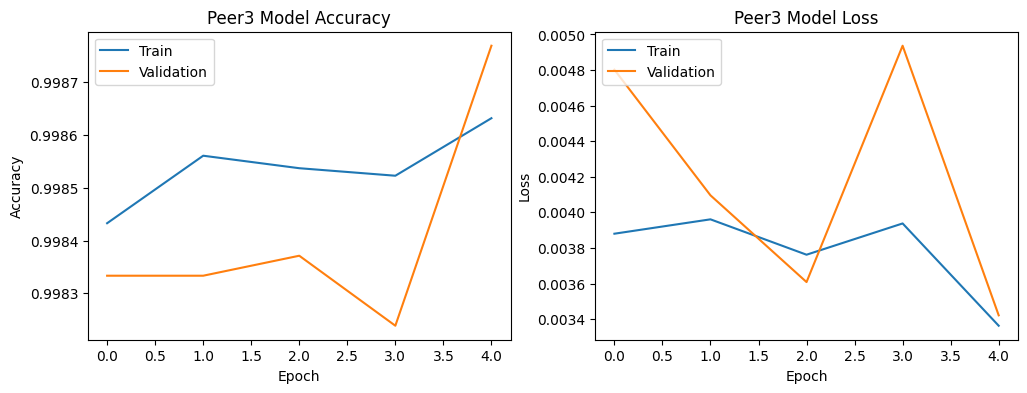

In [34]:
plot_history(histories[0], peer3['name'])

In [35]:

def evaluate_peer(peer):
    loss, accuracy = peer['model'].evaluate(peer['X_test'], peer['y_test'], verbose=0)
    print(f"{peer['name']} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

evaluate_peer(peer1)
evaluate_peer(peer2)
evaluate_peer(peer3)

Peer1 - Loss: 0.0076, Accuracy: 0.9977
Peer2 - Loss: 0.0064, Accuracy: 0.9975
Peer3 - Loss: 0.0232, Accuracy: 0.9959


In [36]:
def save_model_keras(model, file_path):
    try:
        model.save(file_path)
        print(f"Keras model saved to {file_path}")
    except Exception as e:
        print(f"Error saving Keras model to {file_path}: {e}")


save_model_keras(peer1['model'], 'peer1_model.h5')  
save_model_keras(peer2['model'], 'peer2_model.h5')
save_model_keras(peer3['model'], 'peer3_model.h5')


Keras model saved to peer1_model.h5
Keras model saved to peer2_model.h5
Keras model saved to peer3_model.h5
